In [1]:
'''
Editor: @Hyunhomo
Reference: https://github.com/TobiasGlaubach/python-ml-turbofan
'''

## Import libraries in python
import os
import pandas as pd
import padasip as pa
# pa.filters.FilterRLS(n)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

import scipy.stats as stats
from scipy.stats import ttest_1samp

In [2]:

### Data load (use only FD001 first)
## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']


## Read csv file to pandas dataframe
train_FD001 = pd.read_csv('CMAPSSData/train_FD001.txt', sep= ' ', header=None, 
                          names=cols, index_col=False)
test_FD001 = pd.read_csv('CMAPSSData/test_FD001.txt', sep= ' ', header=None, 
                          names=cols, index_col=False)
RUL_FD001 = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep= ' ', header=None, 
                          names=col_rul, index_col=False)

## Calculate RUL and append to train data
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in train_FD001['unit_nr'].unique():
    mapper[unit_nr] = train_FD001['cycles'].loc[train_FD001['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
train_FD001['RUL'] = train_FD001['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD001['cycles']


## Excluse columns which only have NaN as value
# nan_cols = ['sensor_{0:02d}'.format(s + 22) for s in range(5)]
cols_nan = train_FD001.columns[train_FD001.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')
cols_const = [ col for col in train_FD001.columns if len(train_FD001[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')


train_FD001 = train_FD001.drop(columns=cols_const + cols_nan)
test_FD001 = test_FD001.drop(columns=cols_const + cols_nan)

## Check loaded data
print (train_FD001)
print (test_FD001)
print (RUL_FD001)


Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

       unit_nr  cycles    os_1    os_2  sensor_02  sensor_03  sensor_04  \
0            1       1 -0.0007 -0.0004     641.82    1589.70    1400.60   
1            1       2  0.0019 -0.0003     642.15    1591.82    1403.14   
2            1       3 -0.0043  0.0003     642.35    1587.99    1404.20   
3            1       4  0.0007  0.0000     642.35    1582.79    1401.87   
4            1       5 -0.0019 -0.0002     642.37    1582.85    1406.22   
...        ...     ...     ...     ...        ...        ...        ...   
20626      100     196 -0.0004 -0.0003     643.49    1597.98    1428.63   
20627      100     197 -0.0016 -0.0005     643.54    1604.50    1433.58   
20628      100     198  0.0004  0.000

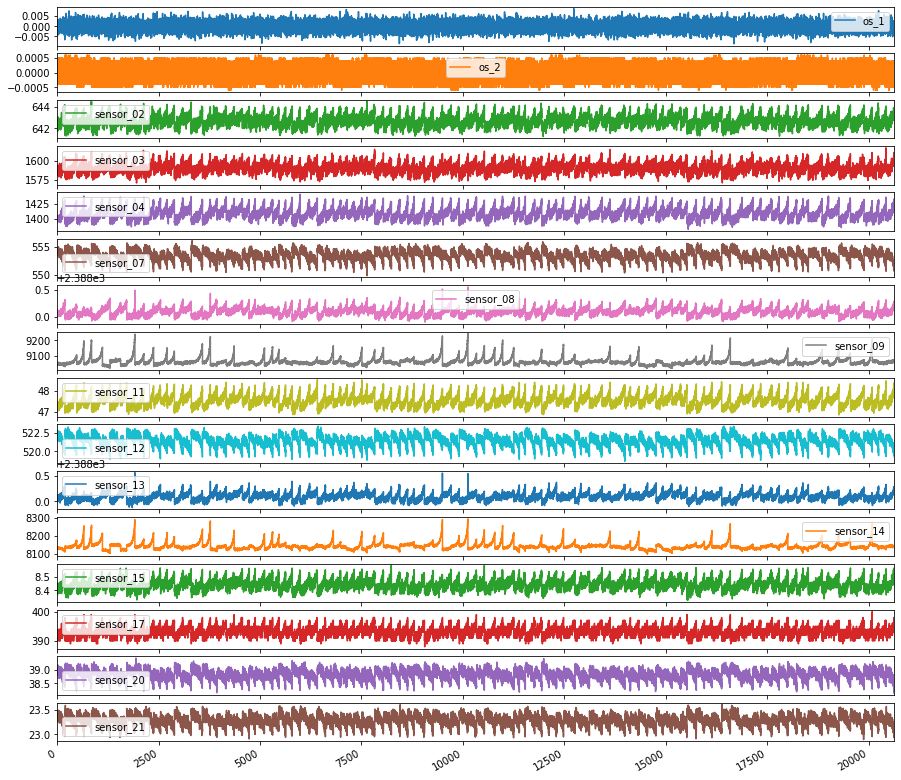

In [3]:
## Plot sensor measurements (time series data) / without normalization
cols_features = [c for c in train_FD001.columns if c.startswith('o') or c.startswith('s')]
t = pd.DataFrame(train_FD001[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))



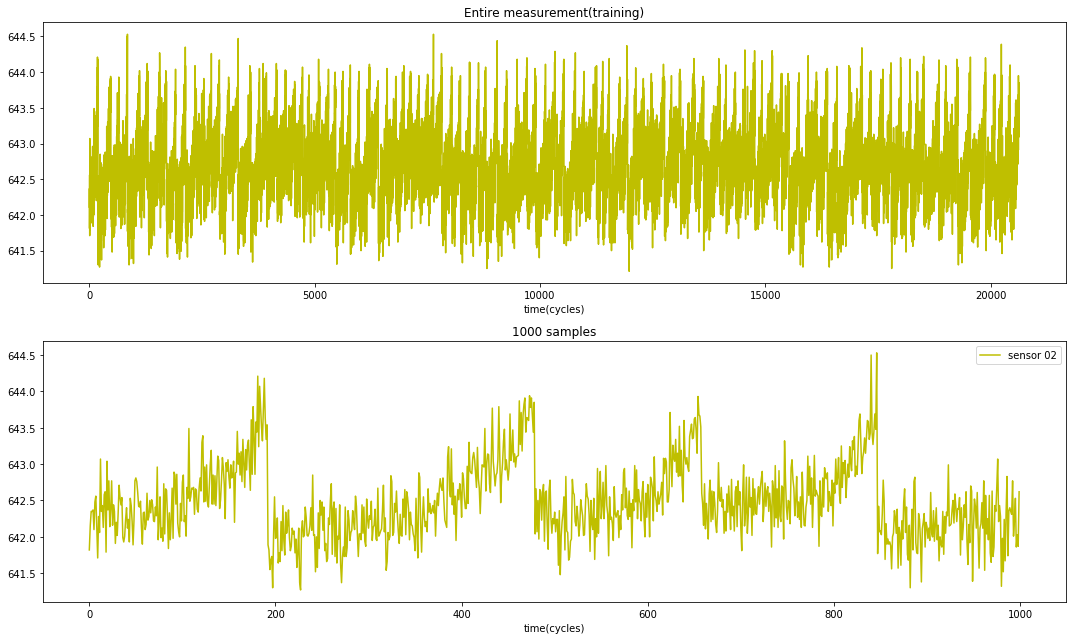

In [4]:
### Prediction error estimation (Anomaly score) with RLS
## Only consider sensor 02
# Assign a time series to numpy array
sensor_02_ts = train_FD001['sensor_02']

# show a time series
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Entire measurement(training)");plt.xlabel("time(cycles)")
plt.plot(sensor_02_ts,"y", label="sensor 02")
plt.subplot(212);plt.title("1000 samples");plt.xlabel("time(cycles)")
plt.plot(sensor_02_ts[:1000],"y", label="sensor 02")
plt.legend(); plt.tight_layout(); plt.show()


In [5]:
### function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
#     print ("data_matrix", data_matrix)
#     print (" data_matrix.shape",  data_matrix.shape)
#     print ("data_matrix.shape[0]", data_matrix.shape[0])
    num_elements = data_matrix.shape[0]
#     print ("num_elements", num_elements)
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements - seq_length - pred_length), range(seq_length, num_elements - pred_length)):
        yield data_matrix[start:stop, :]


        
def gen_target(id_df, seq_length, pred_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
#     print (" data_matrix.shape",  data_matrix.shape)
    num_elements = data_matrix.shape[0]

#     print ("num_elements", num_elements)
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(seq_length, num_elements  -pred_length), range(seq_length + pred_length , num_elements )):
        yield data_matrix[start:stop, :]
        
        
        
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements- pred_length, :]
        
        

In [16]:
### Define functions for anomaly detection (analysis of prediction errors)
'''

'''


def EWMA_Calc(epsilon, mu, lmbd_mu):
    """
    epsilon - input value for current time stamp (prediction error)
    mu - previous EWMA (average of until previous time stamp)
    lmbd_mu - a constant smoothing factor for EWMA weighting decrease
    """
    # calculation formula
    ewma = (lmbd_mu * epsilon) + ((1-lmbd_mu)*mu) 
    # return the result
    return ewma




def EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma):
    """
    epsilon - input value for current time stamp (prediction error)
    anomaly - True(1)/False(0) of anomaly until previous time stamp
    mu - previous EWMA (average of until previous time stamp)
    sigma - previous absolute deviation
    lmbd_mu - a constant smoothing factor for EWMA weighting decrease
    lmbd_sigma - a constant smoothing factor for the calculation of updating absolute deviation
    """
    if anomaly == True :
        # update absolute deviation(sigma) if there is no anomaly up to now
        sigma = EWMA_Calc ( abs(epsilon - mu), sigma , lmbd_sigma )
        
    # update EWMA 
    mu = EWMA_Calc( epsilon, mu, lmbd_mu )
    sigma = sigma
    # return mu and sigma, mu(average is always updated, 
    # but abs deviation is updated only when anomaly is False)
    
    return mu, sigma




def InitPhaseOne (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, anomaly=False):
    """
    'initial phase to calculate/update average for the first few time stamps'
    
    """
    mu, sigma = EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma)
    
    return mu, sigma
    
     
    
    
def InitPhaseTwo (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad, anomaly=False):
    """
    'second phase of initialization to adapt threshold'
    thold_ad - threshold factor for the anomaly detection 
    
    """
    mu, sigma = EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma)    
    
    if abs(epsilon - mu) > sigma * thold_ad : 
        thold_ad = abs(epsilon - mu) / sigma
    
    
    return thold_ad





def InitPhasePvalue (epsilon, mu, sigma, thold_p, conf_lv = 0.05):
    """
    'induce thold_p value to evaluate p-value in detection step'
    thold_p - threshold factor for the p-value
    conf_lv - user defined confidence level, 0.05 means 95%
    
    """       
    fixed_thold = stats.norm.ppf(conf_lv, loc = mu, scale = thold_p*sigma)
    deviation_thold = abs(fixed_thold - mu)
    
    # loop until thold_p shows can be enough variance in normal distribution    
    while abs(epsilon-mu)> deviation_thold :
        thold_p += 0.1        
        fixed_thold = stats.norm.ppf(conf_lv, loc = mu, scale = thold_p*sigma)
        deviation_thold = abs(fixed_thold - mu)
        
    
    return thold_p



    
    
def Detection (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad, thold_p, anomaly=False):
    
    '''
    main function which detect anomaly and calculate p-value
    epsilon - current inpur prediction error
    anomaly - default is False, the detection result (True/False) will be return
    mu, sigma - updated average or deviation value during initalization phase
    lmbd_mu, lmbd_sigma - manually selected smoothing factor for EWMA calculation
    thold_ad, thold_p - adaptive threshold factor value, initial value is determined in inital phase
    
    '''
    
    if abs(epsilon - mu) > sigma * thold_ad : 
        anomaly = True
    
    
    mu, sigma = EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma)
    
    # half tailed p-value (only concerning deviation from the mean, range:[0,0.5])
    # if p_value is supposed to be used for anomaly detection, 
    # then anomaly is true when p_value is larger than conf_lv(user defined confidence level)  
    if epsilon > mu :
        p_value = stats.norm.sf(epsilon, mu, thold_p*sigma) #p-value right tailed (right hand side of mean)
    else :
        p_value = stats.norm.cdf(epsilon, mu, thold_p*sigma) #p-value left tailed (left hand side of mean)
    print (p_value)

    
    return anomaly, p_value



mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:0, signma:0, thold_ad:10, thold_p:10
mu:236.87376722793925, signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.8848508], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.22086715], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.12282023], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.0068946], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.0632883], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.1779928], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.18174466], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.06738924], signma:237.33961180906175, thold_ad

mu:[-0.2591428], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.11826706], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.22373004], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.09236773], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.2212887], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.00876354], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.21753598], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.49666899], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.18019182], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.71428621], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.31996052], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.52462274], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.16636241], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.04402602], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.08838945], signma:237.33961180906175, 

mu:[0.61732925], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.15417243], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.10361809], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.25067906], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.27367367], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.68902781], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.14782518], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.3883159], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.21714216], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.00652653], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.78788581], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.50537126], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.37126597], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.39351082], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.18643658], signma:237.33961180906175,

mu:[0.19836997], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.15281865], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.54994152], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.18414263], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.31423783], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.33110988], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.33383788], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.2923856], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.11315087], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.4652911], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.20694426], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.30743315], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.03002185], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.41785778], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.26081217], signma:237.33961180906175

mu:[-0.47971489], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.35134084], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.63446808], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.15360018], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.106694], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.82924916], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.40509589], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.33870946], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.59225967], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.12173795], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.62586258], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.01306888], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.14690455], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.63495682], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.4611151], signma:237.33961180906175, 

mu:[0.29719308], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.18179285], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.60051414], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.48942106], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.97243153], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.14842755], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23654136], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.08551732], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23491555], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.20197897], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.45925831], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.07126686], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.55524879], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.10008155], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.74774289], signma:237.33961180906175

mu:[-0.3498507], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.07858223], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.117673], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.07964048], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.29616788], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.27959263], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.63088369], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.68875114], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.97732938], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.42674348], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.32307595], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.20086965], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.31721262], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.02872071], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.21177123], signma:237.33961180906175, 

mu:[0.09253854], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.24591454], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.11905143], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.26300802], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.22502016], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.05177224], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.19847558], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.71819786], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.02829923], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.31323257], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.25669293], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.65932026], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.27866157], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.45735071], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.04064796], signma:237.3396118090

mu:[0.1710537], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.14651753], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.53440238], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.10305473], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.48113729], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.10186081], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.09428221], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.11629396], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.45405194], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.39883157], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.09059826], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.37915281], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.57557613], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.31979529], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.10401233], signma:237.33961180906175

mu:[0.49852249], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-1.12913426], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.53944529], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.34249077], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.21248386], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.07262344], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.27012311], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.07278747], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.61870764], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.84517912], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.22340577], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.55292059], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.30972126], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[0.26038327], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.75721552], signma:237.339611809061

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961

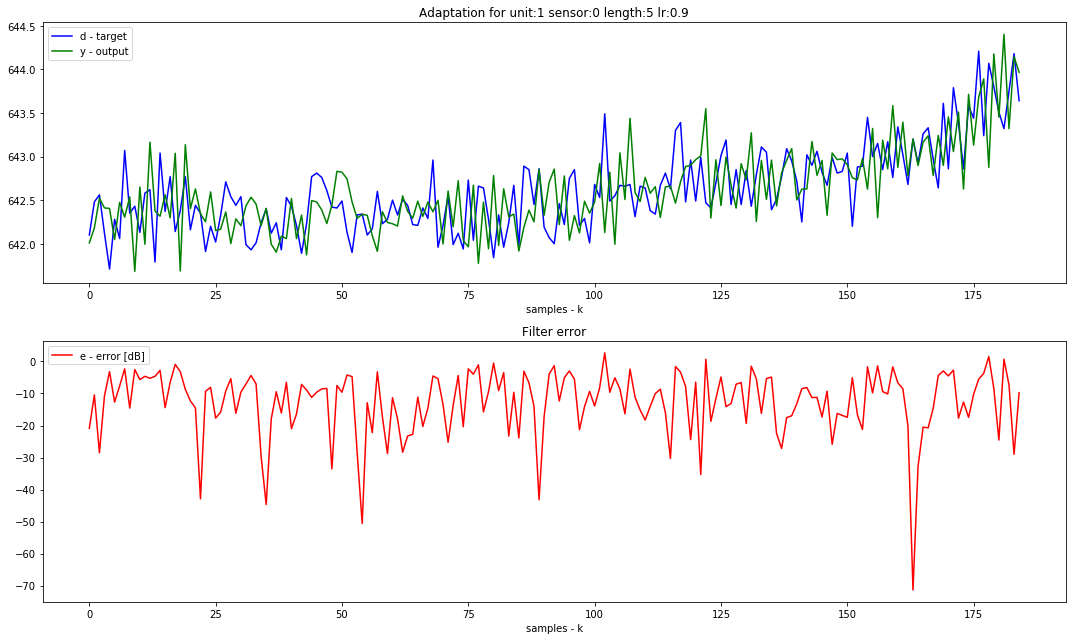

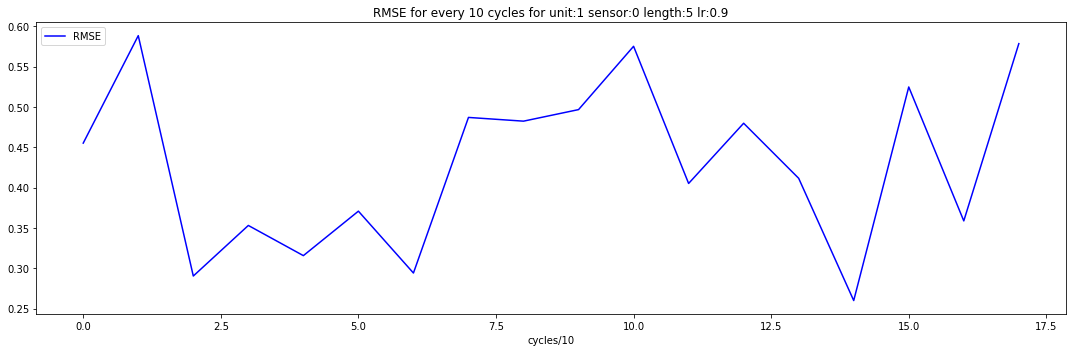

mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:[-0.23874209], signma:237.33961180906175, thold_ad:10, thold_p:10
mu:168.1849926320098, signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.86976414], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.20398262], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-11.11584692], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[7.62682932], signma:168.99120960308

mu:[4.32505412], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-3.95394145], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[3.57005865], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.7149094], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.38044459], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.30937305], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[9.26529812], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-4.85010867], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.85728784], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-4.28564352], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[6.61125208], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-11.79387324], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[5.58789306], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-8.45378458], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.63780389], signma:168.991209603082, thold_ad:10, thold_p:10
mu

mu:[-3.98912197], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.91581508], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.51028702], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-7.75209008], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[3.66605726], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[5.04037061], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-15.78745105], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[3.58786462], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[10.13879923], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-11.02939932], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.16317233], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[15.38065146], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-11.99269705], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.86362857], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[7.19057599], signma:168.991209603082, thold_ad:10, thold_p:10


mu:[-11.98815445], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-4.6188726], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[9.46580546], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[5.83684255], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-7.68160216], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.28293402], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[4.55356144], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-5.0393936], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.51273627], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-5.53675161], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.03559203], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-2.10041401], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[11.90388509], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-7.64823512], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-6.93018784], signma:168.991209603082, thold_ad:10, thold_p:10
mu

mu:[7.23705027], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[5.93387417], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-7.77527598], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[6.74818084], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-8.75434332], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-8.28677762], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[9.69203199], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.38966687], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-9.52108469], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.08828135], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[8.62812672], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[3.28638202], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-14.41675203], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[6.50288374], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[10.54774647], signma:168.991209603082, thold_ad:10, thold_p:10
m

mu:[-14.15010001], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[11.69303821], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.41749779], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-2.96020808], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.81926735], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.75127532], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[3.71883986], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-9.5047713], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.33460385], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[5.6676045], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[7.44096948], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-10.05176242], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.28764428], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[6.10426461], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.70198129], signma:168.991209603082, thold_ad:10, thold_p:10
mu:

mu:[-1.20595023], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.56072337], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.45400481], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.46694302], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-2.22139667], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.16553552], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.54246336], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.02531472], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-14.34224521], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.04618825], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[8.49329445], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-6.96917412], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[7.35010731], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-3.73330447], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[4.95423613], signma:168.991209603082, thold_ad:10, thold_p:10
mu:

mu:[-2.77680207], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[6.31448393], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-4.0147468], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-3.30436669], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[7.91610372], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.38285617], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.19585099], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[2.73982833], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.07743035], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-5.49049778], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.37495525], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[14.2127449], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-20.48445594], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.43530391], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[15.21696682], signma:168.991209603082, thold_ad:10, thold_p:10


mu:[0.62832377], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.06059533], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.01410983], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.42553035], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.87261942], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.36169647], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-3.98460333], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[7.84319381], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-5.0164322], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-2.63764326], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[8.84179432], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-3.85112591], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-2.07845808], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[13.25298624], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-11.28379504], signma:168.991209603082, thold_ad:10, thold_p:10
m

mu:[-4.2706066], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.18221335], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[10.14139625], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-10.92665102], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[1.79349507], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[11.64982721], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-6.34389456], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-7.7767685], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[13.16469633], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[0.15564811], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-16.64750772], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[9.97774483], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[4.62507194], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-1.46674079], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-10.01352992], signma:168.991209603082, thold_ad:10, thold_p:10

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_

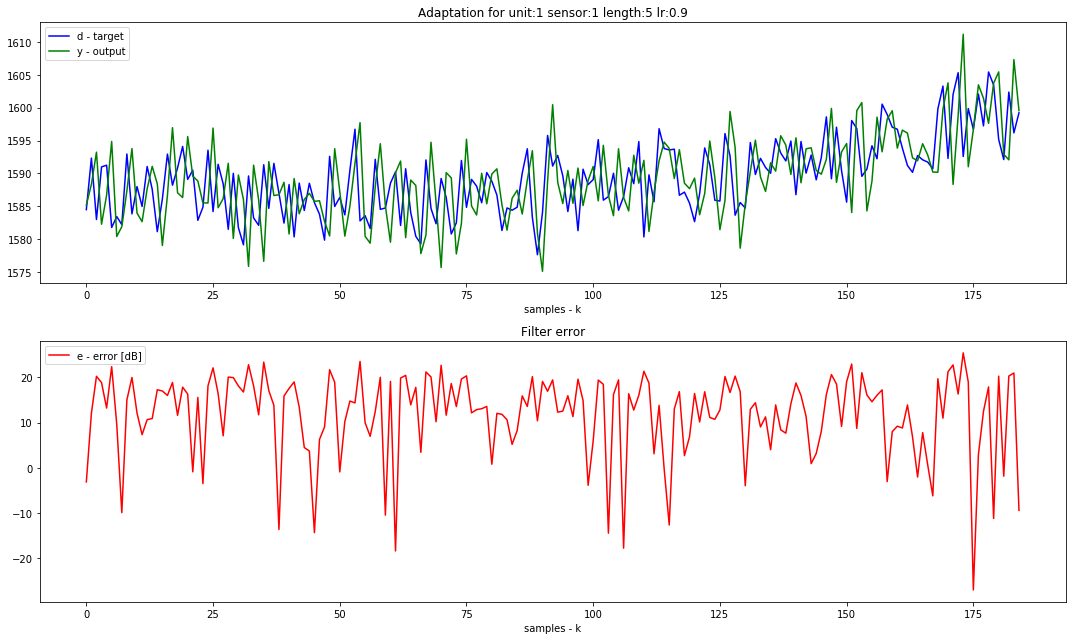

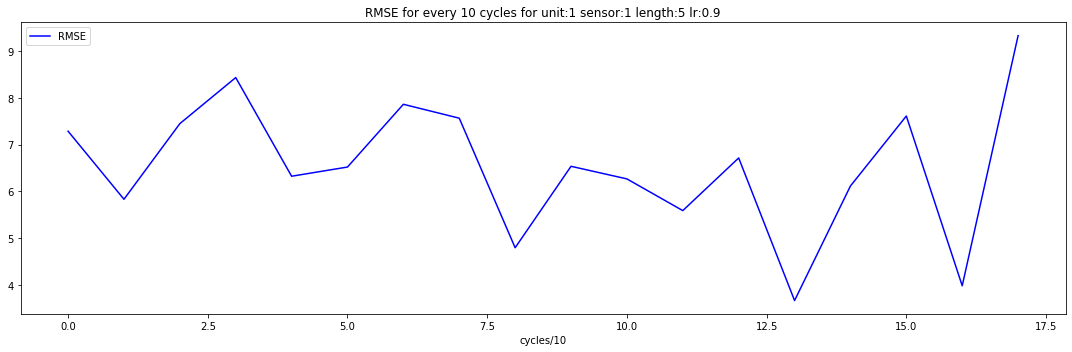

mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:[-0.82937266], signma:168.991209603082, thold_ad:10, thold_p:10
mu:155.39749447623768, signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-7.89330395], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.68041419], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[12.31529147], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.37473684], signma:162.2322225939193, thold_ad:1

mu:[-6.06267426], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.34893861], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.2425579], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.68569426], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.82995744], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.98619552], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.74848597], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.36049029], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.44699506], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.51139636], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.15354552], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.620081], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.13087149], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.87215231], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.92494543], signma:162.2322225939193, thold_ad:10, th

mu:[5.30611753], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.26305778], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.86373477], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.24222243], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.72583157], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.0595399], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.42990645], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[8.15151498], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-7.88048803], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[6.0635393], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.20101944], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.59003381], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-6.42933154], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.73801315], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.49411936], signma:162.2322225939193, thold_ad:10, th

mu:[2.2045865], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.25739871], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.57463494], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.84113535], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[7.63924987], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-6.32691433], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-10.92080765], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.11046843], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[13.97464515], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.52427121], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.95377018], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.93075043], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[8.35906669], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.78240066], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.58416791], signma:162.2322225939193, thold_ad:1

mu:[-1.41834046], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.98759101], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[9.30186572], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-11.61218275], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.71631899], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.63475403], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.37596468], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-9.98222306], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[11.53714837], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[6.00180806], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[9.79322116], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-7.54851081], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.13782007], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.7742807], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.67055241], signma:162.2322225939193, thold_ad:10

mu:[10.21956134], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.45607353], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.55408188], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.62639057], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.95408121], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-7.35043847], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.26208226], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.73004264], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[8.65914159], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.92602211], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.58154425], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-6.66582404], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[12.13827757], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.34534408], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.05755593], signma:162.2322225939193, thold_ad:

mu:[0.52212641], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.45163237], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.67696694], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.14634228], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.85082463], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[8.09737291], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.42938214], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.44104976], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[2.79401117], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.894103], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.33677093], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.5098691], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.48681375], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.89084563], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[4.01544895], signma:162.2322225939193, thold_ad:10, tho

mu:[-5.90392658], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[4.22327553], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[11.45373527], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.56942874], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.08787042], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.60511415], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.00999997], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.7888434], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.59641965], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.86579813], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.82211117], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.86292935], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.21664549], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.44153113], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[6.46049597], signma:162.2322225939193, thold_ad:1

mu:[-0.76922177], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.86884396], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.73257344], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.53138839], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.65556137], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-6.82848813], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-9.88522381], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[8.76646915], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.5116038], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[7.92685232], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.01078376], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.51632251], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.78033848], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[4.05495054], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.65947927], signma:162.2322225939193, thold_ad:1

mu:[-3.2809161], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[4.54628512], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.55074649], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.37495806], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.23527242], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.34664709], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[1.49688393], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[8.47317205], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-10.570521], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.69439267], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[6.67734324], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[5.36195212], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-14.52750784], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[7.46795934], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.84845211], signma:162.2322225939193, thold_ad:10,

mu:[7.19806876], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-3.44292645], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[7.40647756], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-2.81212746], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[0.07906028], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-1.32407312], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-4.94370136], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[6.26843479], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[3.90108896], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.62824912], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-13.00095054], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[15.75818224], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[4.07944836], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-5.89144525], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-11.77802468], signma:162.2322225939193, thold_ad

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thol

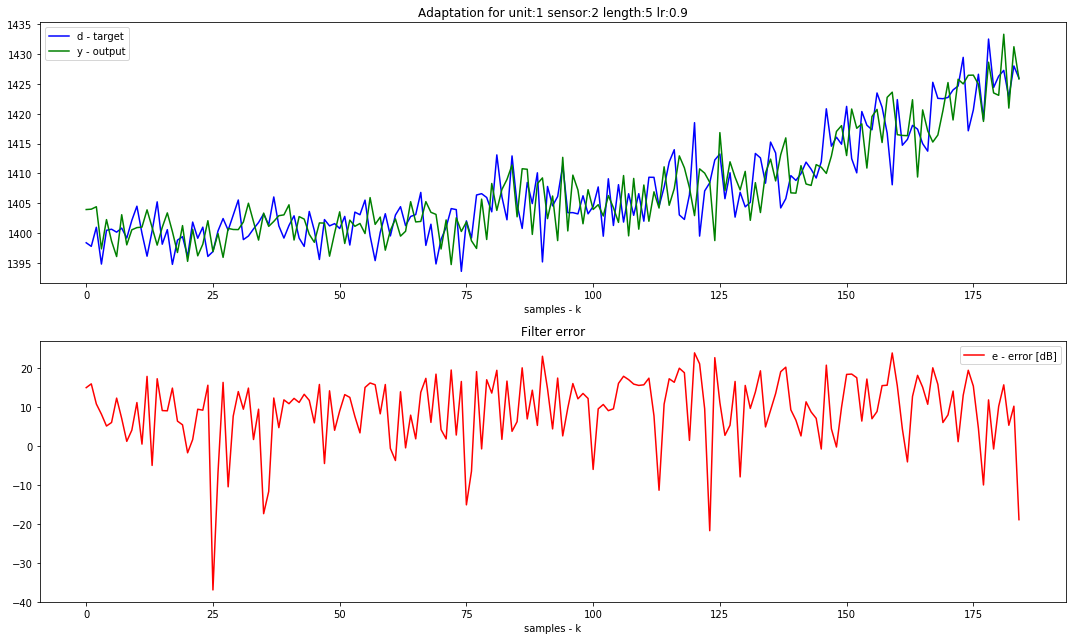

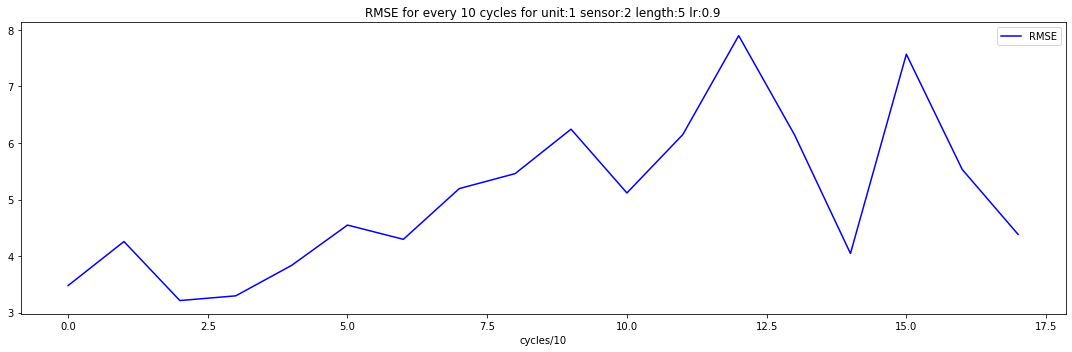

mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:[-0.15582833], signma:162.2322225939193, thold_ad:10, thold_p:10
mu:47.231651215557754, signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.52789996], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.13392241], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[1.43605392], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[1.29183462], signma:47.34363541823479, th

mu:[0.40346613], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-1.58879756], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.42973126], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.44246166], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.46034606], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.18363007], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.12274361], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.3800319], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.68383302], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.12197763], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.36162056], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.05056733], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.97278852], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.64844378], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-1.39735366], signma:47.34363541823479, thold_ad:10, 

mu:[-0.50105142], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.08571267], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.81776847], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.02441276], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.09720735], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.11033813], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.22508682], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.50109858], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.96518195], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.55591526], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-1.06069136], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.29823251], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.54285493], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.04760886], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.95812111], signma:47.34363541823479, thold_ad:1

mu:[0.26028639], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-1.16533169], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-1.34824586], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.26417061], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.97099846], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.72176782], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.34570321], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.13459963], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.28439763], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.26626185], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.08786918], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.54421795], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.51937794], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.0155418], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.73750158], signma:47.34363541823479, thold_ad:10,

mu:[-0.11487614], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.24445471], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.50078696], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.48856975], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.27893369], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.6857179], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.86273165], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.21104343], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[1.23348474], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.29450299], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.88288501], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.00356307], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.31835156], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.89883391], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.08344231], signma:47.34363541823479, thold_ad:10, 

mu:[-0.98703881], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.09726943], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.43948479], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.50017474], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.18788843], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.79212696], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.18093111], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-0.30626953], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[-1.56143848], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.41000887], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[1.2136264], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.28151866], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.35196336], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.78669292], signma:47.34363541823479, thold_ad:10, thold_p:10
mu:[0.32744896], signma:47.34363541823479, thold_ad:10, 

KeyboardInterrupt: 

In [18]:
sequence_length = 5
pred_length = 1
lr = 0.9
# unit_id_idx = 96 # 1~100
sensor_idx = 14  # 0~13, sensor 2,3,4,7,8,9,11,12,13,14,15,17,20 and 21 in order

# RMSE of first n samples and last n samples
n = 10

p_err_u_list = []


### Initialize the parameters for anomaly detection 
anomaly = False
mu = 0
sigma = 0
lmbd_mu = 0.1
lmbd_sigma = 0.1
thold_ad = 10
thold_p = 10


for unit_id_idx in range(5):
    p_err_s_list = []
    unit_id_idx += 1
    for s_i in range(sensor_idx):
            # pick the feature columns
        sensor_dataframe = train_FD001.drop(columns=['unit_nr','cycles','os_1','os_2','RUL'])
        sequence_cols = sensor_dataframe.columns.values.tolist()
    #     print (sequence_cols)

        # generator for the sequences
        # transform each id of the train dataset in a sequence
        seq_gen = (list(gen_sequence(train_FD001[train_FD001['unit_nr'] == id], sequence_length, sequence_cols))
                   for id in np.delete(train_FD001['unit_nr'].unique(),unit_id_idx-1))

        # generate sequences and convert to numpy array
        seq_array  = np.concatenate(list(seq_gen))
        # seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
#         print(seq_array[0])
    #     print(seq_array.shape)


        # generator for the sequences
        # transform each id of the train dataset in a sequence
        target_seq_gen = (list(gen_target(train_FD001[train_FD001['unit_nr'] == id], sequence_length, pred_length, sequence_cols))
                   for id in np.delete(train_FD001['unit_nr'].unique(),unit_id_idx-1))

        # print ("target_seq_gen", target_seq_gen)
        # generate sequences and convert to numpy array
        target_seq_array  = np.concatenate(list(target_seq_gen))
        # target_seq_array = np.concatenate(list(target_seq_gen)).astype(np.float32)
#         print(target_seq_array[0])
#         print(target_seq_array.shape)



        # generate RUL labels
        label_gen = [gen_labels(train_FD001[train_FD001['unit_nr'] == id], sequence_length, ['RUL'])
                     for id in np.delete(train_FD001['unit_nr'].unique(),unit_id_idx-1)]

        label_array = np.concatenate(label_gen).astype(np.float32)



        ### Prediction error estimation with RLS

        ## Check data shape (last instance of each unit is excluded)
    #     print ("other sensors input data shape: " , seq_array[:,:,0].shape)
    #     print ("other sensors target measurement shape: ", target_seq_array[:,:,0].shape)
    #     print ("RUL array shape: ", label_array.shape)

        ## Apadt model first
        ## An example how to filter data measured in real-time
        # these two function supplement your online measurment

        s2_input_array = seq_array[:,:,s_i]
        s2_target_array = target_seq_array[:,:,s_i]

        N = seq_array.shape[0]
        log_d = np.zeros(N)
        log_y = np.zeros(N)

        filt = pa.filters.FilterRLS(sequence_length, mu=lr)
        
        init_p_err_array = np.zeros(10)
        
        for k in range(N-1):
            # measure input
    #         print ("k",k)
            x = s2_input_array[k]
#             print ("x",x)
        #     print (x.shape)
            # predict new value
            y = filt.predict(x)
            # do the important stuff with prediction output
            pass    
            # measure output
            d = s2_target_array[k]
#             print ("d", d)
#             print ("y", y)
            # update filter
            filt.adapt(d, x)
            # log values
            log_d[k] = d
            log_y[k] = y
            
            epsilon = d-y
            """
            Here, after computing prediction error for each sensor of other TTF(R2F) cycle, use those
            prediction erros to initinalize the parameters(factors) for anomaly detection 

            """
            #initialize mean and absolute deviation
            if k < 10 :
                init_p_err_array[k] = epsilon
                
            elif k ==10:
                mu = np.mean(init_p_err_array)
                sigma = abs(init_p_err_array[k-2] - mu)
            
            
            elif k < int((N-1)/2) :
                mu, sigma = InitPhaseOne (epsilon, mu, sigma, lmbd_mu, lmbd_sigma)
                
            else :
                thold_ad = InitPhaseTwo (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad)
                thold_p = InitPhasePvalue (epsilon, mu, sigma, thold_p, conf_lv = 0.05)
            
            print ("mu:%s, signma:%s, thold_ad:%s, thold_p:%s" %(mu,sigma, thold_ad, thold_p))



        ## sequence of time series data and target measurement values for selected machine (unit_id_idx)
        seq_gen_m_id = (list(gen_sequence(train_FD001[train_FD001['unit_nr'] == unit_id_idx], sequence_length, sequence_cols))
                   )

        # generate sequences and convert to numpy array
        seq_array_m_id  = np.array(list(seq_gen_m_id))
        # seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
        # print(seq_array_m_id)
    #     print(seq_array_m_id.shape)



        # generator for the sequences
        # transform each id of the train dataset in a sequence
        target_seq_gen_m_id = (list(gen_target(train_FD001[train_FD001['unit_nr'] == unit_id_idx], sequence_length, pred_length, sequence_cols))
                   )

        # print ("target_seq_gen", target_seq_gen)
        # generate sequences and convert to numpy array
        target_seq_array_m_id  = np.array(list(target_seq_gen_m_id))
        # target_seq_array = np.concatenate(list(target_seq_gen)).astype(np.float32)
        # print(target_seq_array_m_id)
    #     print(target_seq_array_m_id.shape)


        #only sensor_02

        s2_input_m_id = seq_array_m_id[:,:,s_i]
        s2_target_m_id = target_seq_array_m_id[:,:,s_i]


        N = s2_input_m_id.shape[0]
        log_d = np.zeros(N-1)
        log_y = np.zeros(N-1)
        p_err_array = np.zeros(N-1)
        for k in range(N-1):
            # measure input
    #         print ("k",k)
            x = s2_input_m_id[k]
#             print ("x", x)
        #     print (x.shape)
            # predict new value
            y = filt.predict(x)
            # do the important stuff with prediction output
            pass    
            # measure output
            d = s2_target_m_id[k]
#             print ("d", d)
#             print ("y", y)
            # update filter
            filt.adapt(d, x)
            # log values
            log_d[k] = d
            log_y[k] = y
            # save prediction error to array for each sensor
            p_err_array[k] = d-y
            
            """
            Use Initilized paramters above to compute anomaly and p value,
            compute every loop( online)
            anomaly(True/False) and p-value will be assigned into array/list and display
            
            """

        
        # An array of each sensor is appended to list
        p_err_s_list.append(p_err_array)


        ### show results
        plt.figure(figsize=(15,9))
        plt.subplot(211);plt.title("Adaptation for unit:%s sensor:%s length:%s lr:%s" %(unit_id_idx,s_i, sequence_length, lr));plt.xlabel("samples - k")
        plt.plot(log_d,"b", label="d - target")
        plt.plot(log_y,"g", label="y - output");plt.legend()
        plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
        plt.plot(10*np.log10((log_d-log_y)**2),"r", label="e - error [dB]")
        plt.legend(); plt.tight_layout(); plt.show()




        ## Numerical evaluation


        y_actual = log_d
        y_predicted = log_y

        first_n_rmse = sqrt(mean_squared_error(y_actual[:n], y_predicted[:n]))
        last_n_rmse = sqrt(mean_squared_error(y_actual[-n:], y_predicted[-n:]))

    #     print ("first %s cycles RMSE of prediction: %s" %(n,first_n_rmse))
    #     print ("last %s cycles RMSE of prediction: %s" %(n,last_n_rmse))





        '''
        RMSE evaluation with fixed window size n
        '''

        # s2_input_m_id = seq_array_m_id[:,:,sensor_idx]
        # s2_target_m_id = target_seq_array_m_id[:,:,sensor_idx]
        # x = s2_input_m_id
        # d = s2_target_m_id

        # y, e, w = filt.run(d, x)
        # y_actual = d
        # y_predicted = y





    #     print (len(y_predicted))
    #     print (int(len(y_predicted)/n))
        rmse_list = []
        for iter in range(int(len(y_predicted)/n)) :
            rmse_temp = sqrt(mean_squared_error(y_actual[n*iter:n*(iter+1)], y_predicted[n*iter:n*(iter+1)]))
            rmse_list.append(rmse_temp)



    #     print (rmse_list)

        ### show results
        fig_rmse = plt.figure(figsize=(15,5))
        plt.plot(rmse_list,"b", label="RMSE")
        plt.xlabel("cycles/%s" %n)
        plt.title("RMSE for every %s cycles for unit:%s sensor:%s length:%s lr:%s" %(n,unit_id_idx,s_i, sequence_length, lr))
        plt.legend(); plt.tight_layout(); plt.show()
        fig_rmse.savefig("plots/rmse_u_%s_s_%s_len_%s_lr_%s.png" %(unit_id_idx,s_i,sequence_length, lr))

        
        
        
        
    ## list of prediction error (of all sensor per unit) is appended to final list
    
    
    p_err_u_list.append(p_err_s_list)

In [ ]:
'''
p_err_u_list[unit idx][sensor idx][time stamp]

'''



In [ ]:
epsilon = 2.3
mu = -1
sigma = 0

if epsilon > mu :
    p_value = stats.norm.sf(epsilon, mu, sigma) #p-value ad given normal dist
    
else :
    p_value = stats.norm.cdf(epsilon, mu, sigma) #p-value ad given normal dist
print (p_value)


# p_distr = stats.norm.rvs(loc = mu, scale = sigma, size=10000)
# tset, p_value = ttest_1samp(p_distr, epsilon)
# print ('p_value: %2.10f' %p_value)

stats.norm.ppf(0.05, loc = mu, scale = sigma)

# stats.norm.interval(alpha=0.5, loc = mu, scale = sigma)